In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import logging

### Extract

In [ ]:
with open('../Credentials/api_config.json', 'r') as json_file:
    data = json.load(json_file)
    RapidAPIKey = data['X-RapidAPI-Key']
    RapidAPIHost = data['X-RapidAPI-Host']

#### Creating Extract Function to make get request to the API

In [2]:
def extract(cities):
    #Creamos el dataframe al que haremos append por cada iteracion
    df_result = pd.DataFrame()
    for ciudad in cities:
        url = "https://cost-of-living-and-prices.p.rapidapi.com/prices"
        params = {"city_name":ciudad,"country_name":"United States"}
        headers = {
        "X-RapidAPI-Key": RapidAPIKey,
        "X-RapidAPI-Host": RapidAPIHost
        }
        logging.info('')
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            logging.info(f"estoy iterando en {ciudad}")
            
            #Accediendo a la llave prices, para convertir los valores en un dataframe
            logging.info(f"Accedo a la llave prices de mi diccionario en {ciudad}")
            prices = data["prices"] 

            #Creamos la columna city, y la llenamos con su valor correspondiente
            temporal_df = pd.DataFrame(prices)
            temporal_df['city'] = ciudad

            # Concatenar df2 debajo de df1
            df_result = pd.concat([df_result, temporal_df], ignore_index=True)

        except requests.exceptions.RequestException as e:
            print(f"Error en la solicitud para {ciudad}: {e}")

    return df_result

#### First request to the API

Keep in mind that the API only allows 10 requests peer hour, so, when execute this cells, make sure you wait the correspondent time

In [ ]:
cities1 = [
    'New York', 'Harper Woods', 'Huntington Park', 'Oasis Spring', 'Coalville', 'Chicago', 'Seattle', 'Baltimore',
    'Ducktown', 'Mullica Hill']
df1 = extract(cities1)

In [7]:
df1.to_csv('df1_API.csv', index=False)

#### Second request to the API

In [ ]:
cities2 = ['Willingboro', 'Middletown', 'Houston', 'Boston', 'San Diego', 'Ravenswood', 'Seaside Heights',
    'Isla Vista', 'Beeville', 'Holderness']
df2 = extract(cities2)

In [9]:
df2.to_csv('df2_API.csv', index=False)

In [4]:
df1 = pd.read_csv('df1_API.csv')
df2 = pd.read_csv('df2_API.csv')
df = pd.concat([df1, df2])

#### Concatenating the dataframes into a single one.

In [5]:
df = pd.concat([df1, df2])
df.head(2)


,Unnamed: 0,good_id,item_name,category_id,category_name,min,avg,max,usd,measure,currency_code,city
0,0,1,Price per square meter to Buy Apartment Outsid...,1,Buy Apartment,3767.37,8048.65,12329.93,"{'min': '3767.37', 'avg': '8048.65', 'max': '1...",money,USD,New York
1,1,2,Price per square meter to Buy Apartment in Cit...,1,Buy Apartment,10919.00,16308.41,21697.82,"{'min': '10919.00', 'avg': '16308.41', 'max': ...",money,USD,New York


#### Identifying data types

In [6]:
df.dtypes

Unnamed: 0         int64
good_id            int64
item_name         object
category_id        int64
category_name     object
min              float64
avg              float64
max              float64
usd               object
measure           object
currency_code     object
city              object
dtype: object

####  Dimensions of the dataset

In [7]:
df.shape

(836, 12)

#### How many null do we have for each variable

In [8]:
(
    df
    .isnull()
    .sum()
    .sort_values(ascending=False)
)

usd              19
currency_code    19
Unnamed: 0        0
good_id           0
item_name         0
category_id       0
category_name     0
min               0
avg               0
max               0
measure           0
city              0
dtype: int64

#### Null's proportion for each variable

c:\Users\SANTIAGO\Python\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


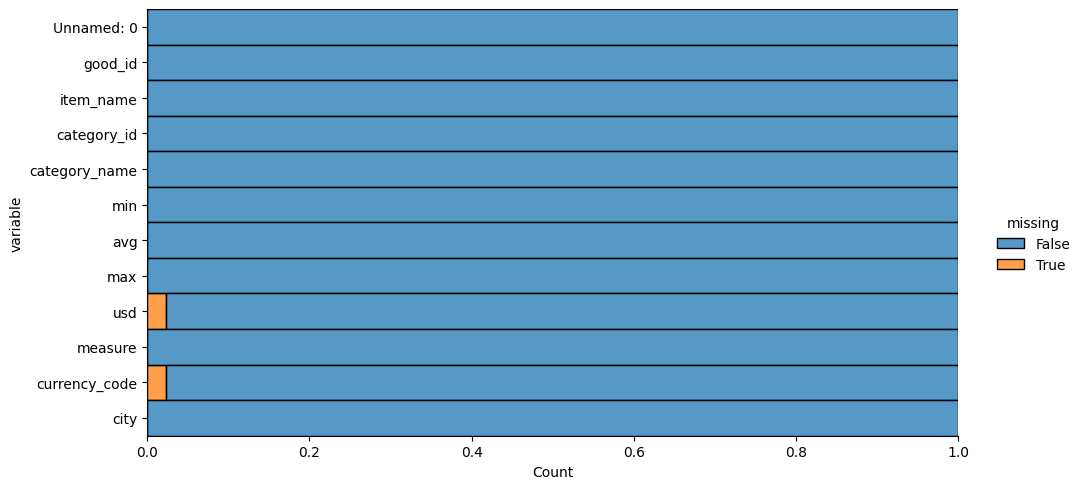

In [9]:
(
    df
    .isnull()
    .melt(value_name='missing')
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='missing',
                multiple='fill',
                aspect=2
            )
        )
    )
)

#### How are distributed the category's items

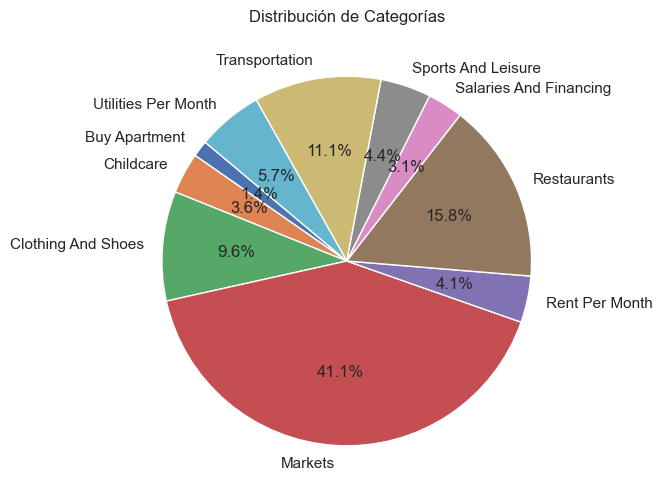

In [10]:
conteo_por_categoria = df.groupby('category_name').size().reset_index(name='conteo')
conteo_por_categoria
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
plt.pie(conteo_por_categoria['conteo'], labels=conteo_por_categoria['category_name'], autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Categorías')
plt.show()

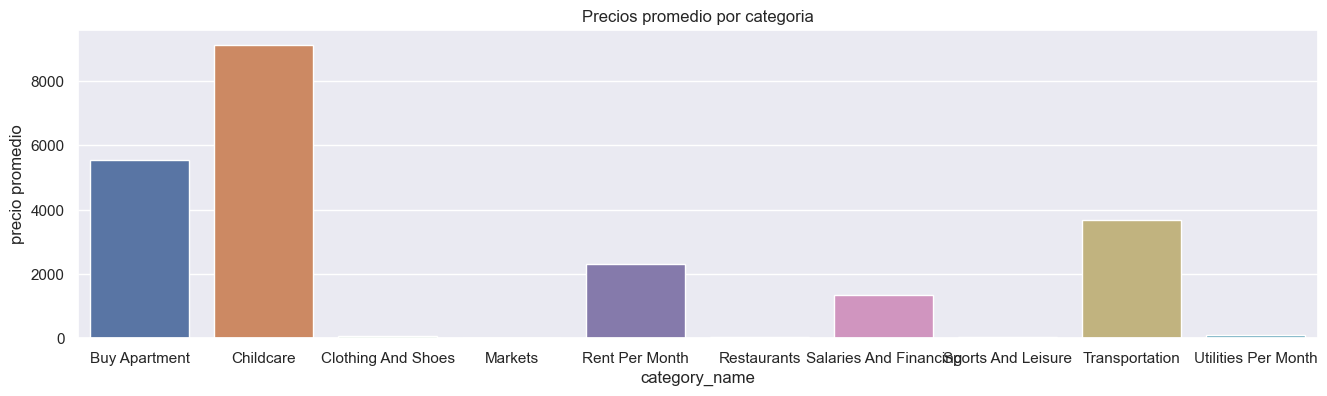

In [21]:
precios_promedio_por_categoria = df.groupby('category_name')['avg'].mean().reset_index(name='precio promedio')
precios_promedio_por_categoria
plt.figure(figsize=(16, 4))
sns.set(style="darkgrid")
sns.barplot(x = 'category_name', y = 'precio promedio', data = precios_promedio_por_categoria)
plt.title('Precios promedio por categoria')
plt.show()

When reviewing the previous chart, we can see certain inconsistencies because there is no defined time frame for all categories... So, it is considered a better option to review category by category what items each one has and their prices.

#### Average Prices Related with restaurants

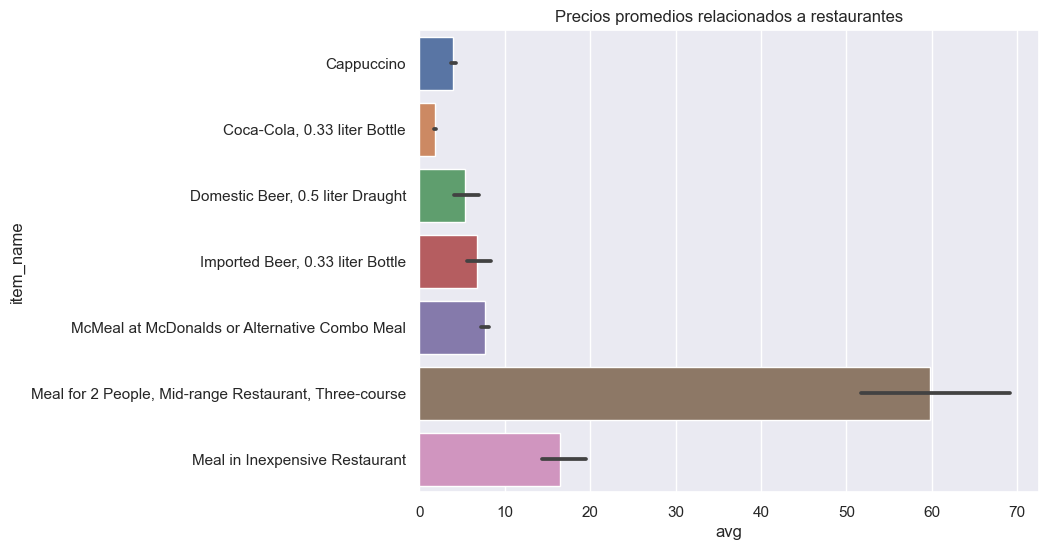

In [22]:
restaurants_df = df[df['category_name']== 'Restaurants']
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
sns.barplot(x = 'avg', y = 'item_name', data = restaurants_df)
plt.title('Precios promedios relacionados a restaurantes')
plt.show()

#### Average Prices Related with rents 

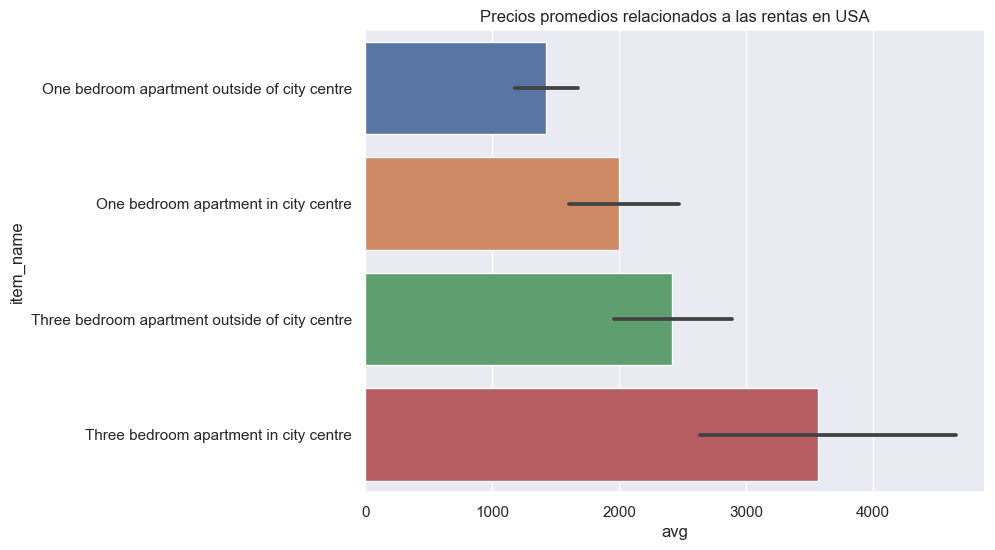

In [13]:
rent_df = df[df['category_name']== 'Rent Per Month']
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
sns.barplot(x = 'avg', y = 'item_name', data = rent_df)
plt.title('Precios promedios relacionados a las rentas en USA')
plt.show()


#### Average Prices Related with Markets

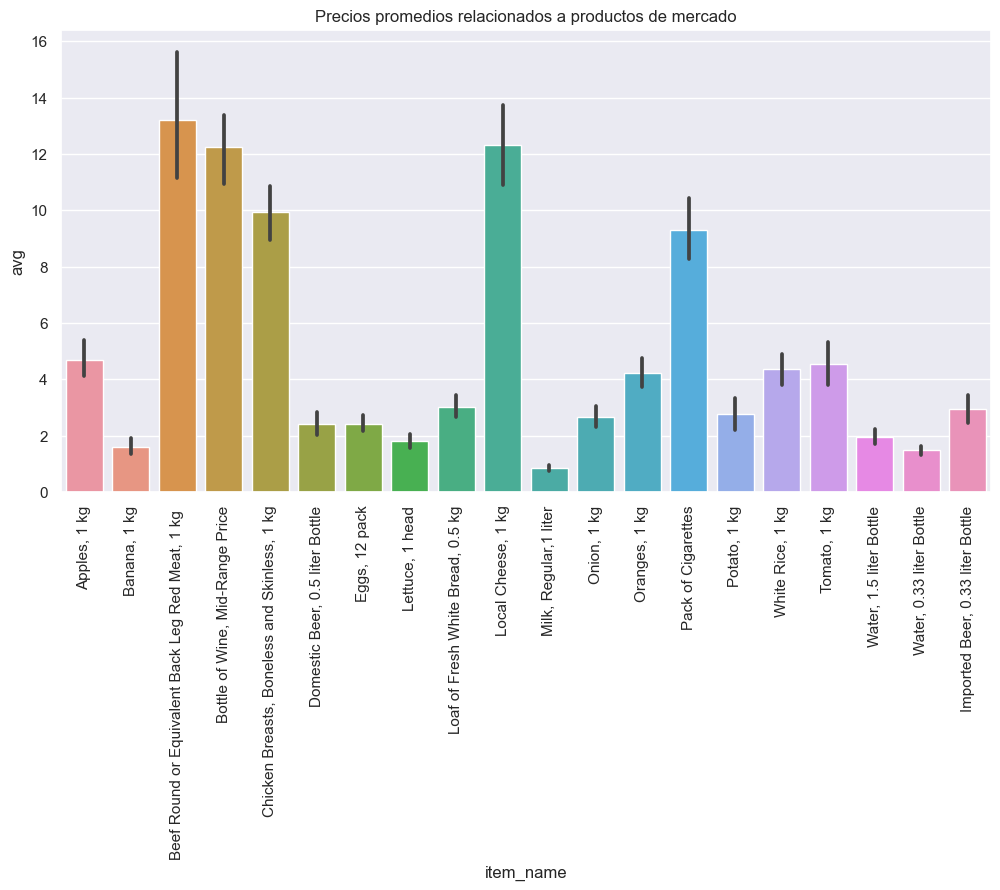

In [14]:
markets_df = df[df['category_name']== 'Markets']

plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
barplot = sns.barplot(x='item_name', y='avg', data=markets_df)

# Rotar las etiquetas del eje X en 45 grados para mejorar la legibilidad
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

plt.title('Precios promedios relacionados a productos de mercado')
plt.show()


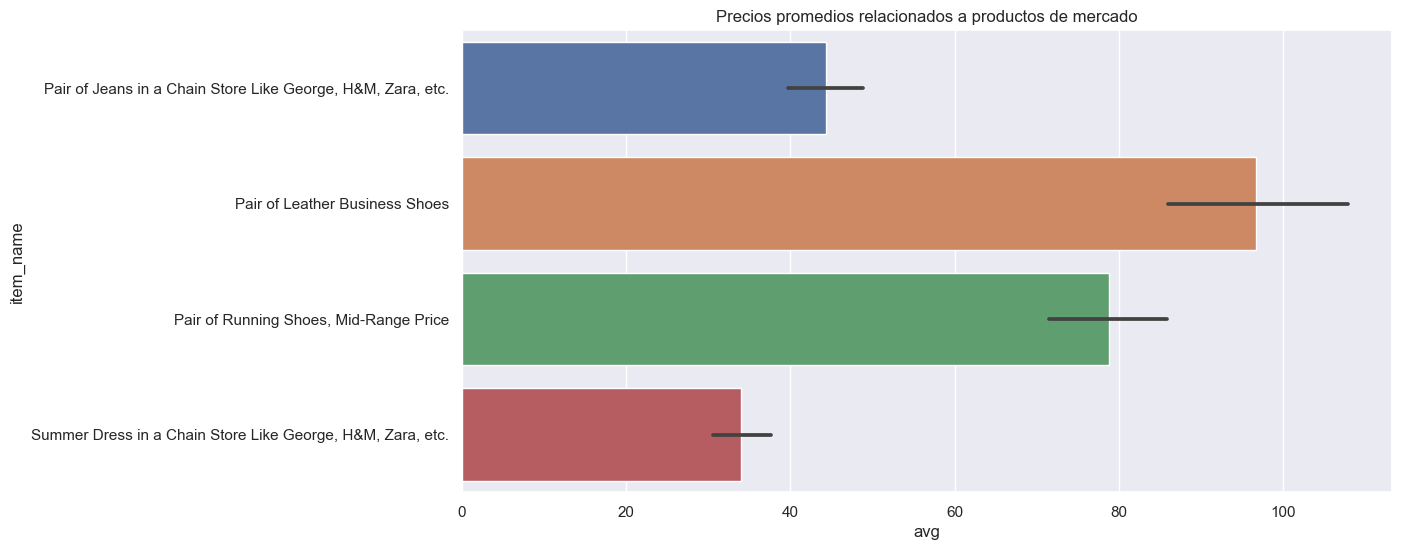

In [15]:
clothing_df = df[df['category_name']== 'Clothing And Shoes']

plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
barplot = sns.barplot(x='avg', y='item_name' , data=clothing_df)

# Rotar las etiquetas del eje X en 45 grados para mejorar la legibilidad
#barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

plt.title('Precios promedios relacionados a productos de mercado')
plt.show()

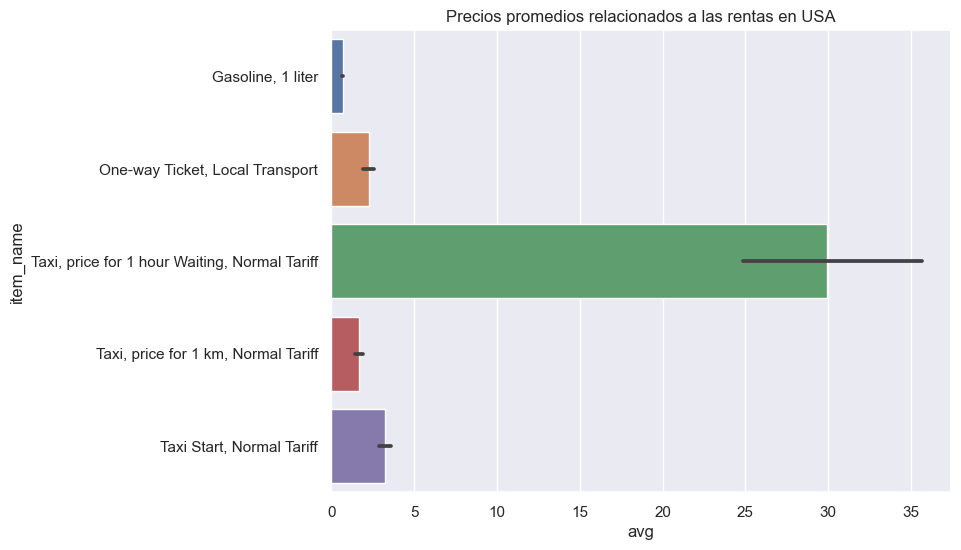

In [18]:
transportation_df = df[df['category_name']== 'Transportation']
transportation_df = transportation_df[transportation_df['item_name'] != 'Volkswagen Golf 1.4 90 KW Trendline (Or Equivalent New Car)']
transportation_df = transportation_df[transportation_df['item_name'] != 'Monthly Pass, Regular Price']

plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
sns.barplot(x = 'avg', y = 'item_name', data = transportation_df)
plt.title('Precios promedios relacionados a las rentas en USA')
plt.show()